Most of the simulations in Molecular dynamics require Periodic boundary conditions to simulate bulk properties of a material. While many of the fast near neighbour searches are already in place, their periodic implementation in a triclinic cell is a challenge. Inorder to  implement periodic boundary condition, one has to produce images of all the particles in the neighbourhood cells. Minimum distance of the particle from the any of the image is designated as the pairwise distance between a set of particles. Ideally, to capture the images of all the particles in the vicinity of the cell, the cutoff distance should be half the cellsize, but typically the requirements of near neighbour distances are quite small compared to the box(cell) length. The box can therefore extended till a small cutoff distance and particles within the range can be duplicated. This extended box can then be supplied to the near neighbour searching algorithms which are PBC unaware. 


An implementation for PBC which is KDtree specific, is implemented in MDAnalysis. This can be used as a reference to check the performance of the above mentioned algorithm. More information about the duplication can be found [here](http://www.richardjgowers.com/2018/06/28/make_halos.html). Furthermore, as reported in this [benchmarks](http://nbviewer.jupyter.org/url/jakevdp.github.com/downloads/notebooks/memview_bench.ipynb), huge time reduction can be achieved by using cython functions as all the loops in the code are relatively constly in python.

Lets begin by comparing the performance of two non periodic tree structures 

* KDtree in BioPython  
* cKDTree in Scipy

In [5]:
import MDAnalysis as mda
import numpy as np

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

In [23]:
from Bio.KDTree import KDTree
def biopython_build(coords):
    kdtree = KDTree(dim=3)
    kdtree.set_coords(coords)
    return kdtree
def biopython_query(struct, coords, pos, cutoff):
    struct.search(pos,cutoff)
    return np.asarray(struct.get_indices())

In [22]:
from scipy import spatial
def scipy_build(coords):
    return spatial.cKDTree(coords)
def scipy_query(struct, coords, pos, cutoff):
    return np.asarray(struct.query_ball_point(pos,cutoff))

In [24]:
# Helper function for populating the points
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

In [28]:
# Setup
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 10.
NPOINTS = 1000
coords = get_coords(BOX, NPOINTS)
query = BOX[:3]/2

# Check

Assuming all the defined points are inside the centre cell. If not, it is an extra operation which would take similar time in all the algorithms.

In [29]:
skd = scipy_build(coords)
skd_indices = scipy_query(skd, coords, query, CUTOFF)
skd_indices

array([105, 140,   4])

In [30]:
bkd = biopython_build(coords)
bkd_indices = biopython_query(bkd, coords, query, CUTOFF)
bkd_indices

array([140, 105,   4])

In [31]:
np.testing.assert_array_equal(np.sort(skd_indices), np.sort(bkd_indices))

# Timings

In [36]:
from tqdm import tqdm_notebook
from collections import defaultdict

In [37]:
# setup
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
NPOINTS = np.logspace(2, 5, num=10, dtype= np.int)
query = BOX[:3]/2

In [40]:
result_build = defaultdict(list)
result_prune = defaultdict(list)

for N in tqdm_notebook(np.unique(NPOINTS)):
    coords = get_coords(BOX, N)
    #Build
    skd = scipy_build(coords)
    bkd = biopython_build(coords)
        
    #Timings
    res = %timeit -q -o scipy_build(coords)
    result_build['scipy'].append(res.average)
    res = %timeit -q -o biopython_build(coords)
    result_build['biopython'].append(res.average)
    
    #Prune
    res = %timeit -q -o scipy_query(skd, coords, query, CUTOFF)
    result_prune['scipy'].append(res.average)
    res = %timeit -q -o biopython_query(bkd, coords, query, CUTOFF)
    result_prune['biopython'].append(res.average)
    
    result_prune['N'].append(N)

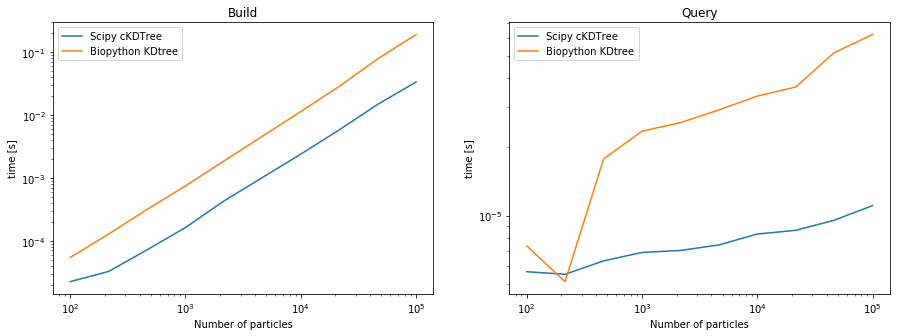

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

ax = axes[0]
ax.plot(result_prune['N'], result_build['scipy'], label="Scipy cKDTree")
ax.plot(result_prune['N'], result_build['biopython'], label="Biopython KDtree")
ax.set(xlabel='Number of particles', ylabel='time [s]', xscale = 'log', yscale='log', title='Build')
ax.legend()

ax = axes[1]
ax.plot(result_prune['N'], result_prune['scipy'], label="Scipy cKDTree")
ax.plot(result_prune['N'], result_prune['biopython'], label="Biopython KDtree")
ax.set(xlabel='Number of particles', ylabel='time [s]', xscale = 'log', yscale='log', title='Query')
ax.legend()


Another variable is the cutoff radius. To deduce the effect of cutoff radius, lets check the variation of cutoff radius for 10000 particles.

In [60]:
# setup
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = np.linspace(2, 15, num=13, dtype=np.float)
NPOINTS = 10000
query = BOX[:3]/2
coords = get_coords(BOX, NPOINTS)

In [61]:
result_prune = defaultdict(list)

for cut in tqdm_notebook(np.unique(CUTOFF)):
    #Build
    skd = scipy_build(coords)
    bkd = biopython_build(coords)

    #Prune
    res = %timeit -q -o scipy_query(skd, coords, query, cut)
    result_prune['scipy'].append(res.average)
    res = %timeit -q -o biopython_query(bkd, coords, query, cut)
    result_prune['biopython'].append(res.average)
    
    result_prune['cut'].append(cut)

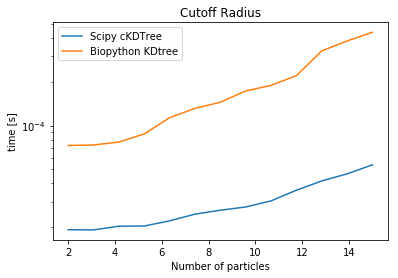

In [64]:
fig, axes = plt.subplots()

axes.plot(result_prune['cut'], result_prune['scipy'], label="Scipy cKDTree")
axes.plot(result_prune['cut'], result_prune['biopython'], label="Biopython KDtree")
axes.set(xlabel='Number of particles', ylabel='time [s]', yscale='log', title='Cutoff Radius')
axes.legend()

As it can be seen that the scipy cKDtree is faster than KDtree implementation in Biopython. It can be definitely replaced in MDAnalysis. 

The above case was only for PBC- unaware systems. As described above, the implementation of periodic boundary condition is necessary to serve the users of MDAnalysis. In the next step, duplication of particles to mimic periodic boundary conditions are shown and compared against the current implementation of periodic KDtree which uses Biopython's extension to pkdtree in pure python. 

The main idea behind the augmented coordinates (as explained [here](http://www.richardjgowers.com/2018/06/28/make_halos.html)) is to duplicate the particles by creating their images in an extended box. These duplicated particles along with the original ones can be used with any non PBC aware near neighbour searching algorithm. All the nearest neighbours can be translated back to their corresponding original coordinates in the central box. Furthermore, since it requires multiple levels of looping and repeated calculations of evaluating the images, huge time reductions are expected by using lower level instructions like cython instead of implementation in pure python. 

For this purpose, we begin by defining the cython functions to create duplicates of the particles.

In [67]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [68]:
%%cython

cimport cython
import cython

cimport numpy as np
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def make_halo(float[:, :] coordinates, float[:] box, float r):
    """Calculate augmented coordinate set
    
    Parameters
    ----------
    coordinates : np.ndarray
      coordinates to augment
    box : np.ndarray
      size of box
    r : float
      thickness of halo region to buffer by
      
    Returns
    -------
    augmented : np.ndarray
      coordinates of the new augmented coordinates
    indices : np.ndarray
      original indices of the augmented coordinates
    """
    cdef bint lo_x, hi_x, lo_y, hi_y, lo_z, hi_z
    cdef int i, j, p, N
    cdef float shiftX[3]
    cdef float shiftY[3]
    cdef float shiftZ[3]
    cdef float coord[3]

    # room for adding triclinic support by using (3,) vectors
    shiftX[0] = box[0]
    shiftX[1] = 0.0
    shiftX[2] = 0.0
    
    shiftY[0] = 0.0
    shiftY[1] = box[1]
    shiftY[2] = 0.0
    
    shiftZ[0] = 0.0
    shiftZ[1] = 0.0
    shiftZ[2] = box[2]
    
    N = coordinates.shape[0]
    p = 0  # output counter
    
    # allocate output arrays
    # could be more conservative with this
    # or use C++ vectors + push etc
    cdef float[:, :] output = np.zeros((N, 3), dtype=np.float32)
    cdef int[:] indices = np.zeros(N, dtype=np.int32)

    for i in range(N):
        for j in range(3):
            coord[j] = coordinates[i, j]
        # detect which face regions particle i is in
        lo_x = coord[0] <= r
        hi_x = coord[0] >= box[0] - r
        lo_y = coord[1] <= r
        hi_y = coord[1] >= box[1] - r
        lo_z = coord[2] <= r
        hi_z = coord[2] >= box[2] - r
        
        if lo_x:
            # if X, face piece
            for j in range(3):
                # add to output
                output[p, j] = coord[j] + shiftX[j]
            # keep record of which index this augmented position was created from
            indices[p] = i
            p += 1
            
            if lo_y:
                # if X&Y, edge piece
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] + shiftY[j]
                indices[p] = i
                p += 1
                
                if lo_z:
                    # if X&Y&Z, corner piece
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] + shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] + shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1
            elif hi_y:
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] - shiftY[j]
                indices[p] = i
                p += 1
                
                if lo_z:
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] - shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                elif hi_z:
                    for k in range(3):
                        output[p, j] = coord[j] + shiftX[j] - shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1

            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] + shiftZ[j]
                indices[p] = i
                p += 1
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] - shiftZ[j]
                indices[p] = i
                p += 1
        elif hi_x:
            for j in range(3):
                output[p, j] = coord[j] - shiftX[j]
            indices[p] = i
            p += 1

            if lo_y:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] + shiftY[j]
                indices[p] = i
                p += 1
                
                if lo_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] + shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] + shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1

            elif hi_y:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] - shiftY[j]
                indices[p] = i
                p += 1
                
                if lo_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] - shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] - shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1

            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] + shiftZ[j]
                indices[p] = i
                p += 1
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] - shiftZ[j]
                indices[p] = i
                p += 1

        if lo_y:
            for j in range(3):
                output[p, j] = coord[j] + shiftY[j]
            indices[p] = i
            p += 1

            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftY[j] + shiftZ[j]
                indices[p] = i
                p += 1
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftY[j] - shiftZ[j]
                indices[p] = i
                p += 1
        elif hi_y:
            for j in range(3):
                output[p, j] = coord[j] - shiftY[j]
            indices[p] = i
            p += 1

            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftY[j] + shiftZ[j]
                indices[p] = i
                p += 1
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftY[j] - shiftZ[j]
                indices[p] = i
                p += 1

        if lo_z:
            for j in range(3):
                output[p, j] = coord[j] + shiftZ[j]
            indices[p] = i
            p += 1
        elif hi_z:
            for j in range(3):
                output[p, j] = coord[j] - shiftZ[j]
            indices[p] = i
            p += 1
            
    return np.array(output[:p]), np.array(indices[:p])


@cython.boundscheck(False)
@cython.wraparound(False)
def undo_augment(int[:] results, int[:] translation, int nreal):
    """Translate augmented indices back to originals
    
    Note: modifies results in place!
    
    Parameters
    ----------
    results : ndarray of ints
      indices of coordinates, including "augmented" indices
    translation : ndarray of ints
      original indices of augmented coordinates
    nreal : int
      number of real coordinates, ie values in results equal or larger than this
      need to be translated to their real counterpart
      
    Returns
    -------
    results : ndarray of ints
    """
    cdef int N
    
    N = results.shape[0]
    
    for i in range(N):
        if results[i] >= nreal:
            results[i] = translation[results[i] - nreal]
            
    return results

Helper function to access the periodic KDTree as implemented in MDAnalysis, as well as the cython functions introduced above.

In [227]:
# Helper function for the cython functions described above
def augment_kdtree(coords, cutoff, box):
    aug, idx = make_halo(coords, box, cutoff)
    aug_coord = np.concatenate([coords, aug])
    print(coords[601], idx)
    kdtree = spatial.cKDTree(aug_coord)
    pairs = np.array(list(kdtree.query_pairs(cutoff)), dtype=np.int32)
    if len(pairs) > 1:
        undo_augment(pairs[:, 0], idx, len(coords))
        undo_augment(pairs[:, 1], idx, len(coords))
    return np.unique(pairs, axis=0)

In [198]:
# PKDtree
import MDAnalysis.lib.distances as distances
def pkdtree(coords, cutoff, box):
    pairs, dist = distances.capped_distance(coords, coords, max_cutoff=cutoff, min_cutoff=1e-7, box=box, method='pkdtree')
    if len(pairs) > 1:
        pairs = pairs[np.where(pairs[:, 0] < pairs[:, 1])[0]]
    return np.asarray(pairs)

# Check

In [193]:
# setup
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
NPOINTS = 1000
coords = get_coords(BOX, NPOINTS)

In [228]:
pairs_pkd = pkdtree(coords, CUTOFF, BOX)
pairs_pkd, pairs_pkd.shape

(array([[  4, 181],
        [  4, 671],
        [  7, 688],
        [  8, 215],
        [  9, 590],
        [ 19,  24],
        [ 19, 543],
        [ 24, 543],
        [ 25, 903],
        [ 35, 234],
        [ 43, 996],
        [ 50, 602],
        [ 56, 509],
        [ 63, 679],
        [ 67, 747],
        [ 68, 641],
        [ 76, 312],
        [ 77, 143],
        [ 78, 465],
        [ 83, 375],
        [ 87, 647],
        [ 92, 109],
        [ 95, 160],
        [102, 237],
        [103, 337],
        [103, 588],
        [113, 322],
        [113, 742],
        [113, 807],
        [114, 408],
        [115, 185],
        [117, 925],
        [121, 866],
        [133, 606],
        [139, 663],
        [142, 539],
        [145, 510],
        [149, 815],
        [158, 291],
        [158, 338],
        [160, 530],
        [167, 201],
        [169, 268],
        [180, 813],
        [181, 671],
        [181, 971],
        [183, 362],
        [183, 547],
        [186, 340],
        [191, 949],


In [229]:
pairs_cy = augment_kdtree(coords, CUTOFF, BOX)
pairs_cy

[ 2.255829 97.07861  97.84134 ] [  0   5   8  12  13  19  19  19  20  21  24  24  24  25  26  37  39  40
  42  44  45  47  47  47  62  67  70  76  77  79  84  89  93  97 101 105
 107 110 113 115 117 122 127 139 141 146 149 161 164 169 173 174 178 182
 185 186 186 186 187 192 194 200 204 210 215 218 227 227 227 230 231 231
 231 236 238 240 243 244 252 257 259 266 271 278 282 287 292 293 296 300
 305 306 313 315 320 322 327 333 333 333 340 340 340 345 347 357 360 366
 371 380 381 382 383 390 399 399 399 404 404 404 410 415 419 423 426 436
 438 439 441 444 454 455 458 460 462 465 467 468 468 468 474 477 479 479
 479 483 486 487 494 495 498 498 498 501 502 506 516 523 524 528 535 542
 543 544 548 551 558 561 565 567 568 569 570 573 574 575 577 586 587 591
 593 601 601 601 601 601 601 601 604 619 627 631 633 637 640 644 652 653
 655 660 661 663 668 682 684 690 693 696 696 696 711 712 713 719 719 719
 722 729 729 729 732 733 740 742 747 753 754 759 761 767 768 768 768 769
 773 778 779 785 79

array([[  4, 181],
       [  4, 671],
       [  7, 688],
       [  8, 215],
       [  9, 590],
       [ 19,  24],
       [ 19, 543],
       [ 24, 543],
       [ 25, 903],
       [ 35, 234],
       [ 43, 996],
       [ 50, 602],
       [ 56, 509],
       [ 63, 679],
       [ 67, 747],
       [ 68, 641],
       [ 76, 312],
       [ 77, 143],
       [ 78, 465],
       [ 83, 375],
       [ 87, 647],
       [ 92, 109],
       [ 95, 160],
       [102, 237],
       [103, 337],
       [103, 588],
       [113, 322],
       [113, 742],
       [113, 807],
       [114, 408],
       [115, 185],
       [117, 925],
       [121, 866],
       [133, 606],
       [139, 663],
       [142, 539],
       [145, 510],
       [149, 815],
       [158, 291],
       [158, 338],
       [160, 530],
       [167, 201],
       [169, 268],
       [180, 813],
       [181, 671],
       [181, 971],
       [183, 362],
       [183, 547],
       [186, 340],
       [191, 949],
       [193, 406],
       [195, 206],
       [197,

In [ ]:
np.unique(np.sort(pairs_cy), axis=0)

It has already been established that the performance of scipy KDtree is better that that of biopython KDtree. The next objective is to check whether the superior performance of nonperiodic KDtree can be replaced with periodic implementation of KDtree in MDAnalysis. For this purpose, the use case is to identify the bonds between the atoms.